In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from DomainPrediction.protein.base import BaseProtein
from DomainPrediction.protein.base import FoldedProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools
from DomainPrediction.utils.tmalign import TMalign
from DomainPrediction.utils.constants import *

In [4]:
root = '../../..'
data_path = '/data/users/kgeorge/workspace/Data'
pmpnn_path = os.path.join(data_path, 'pmpnn_experiments/6mfw_exp')
esm3_path = os.path.join(data_path, 'esm3_experiments/6mfw_exp')
evodiff_path = os.path.join(data_path, 'evodiff_experiments/6mfw_exp')
esm2_random_path = os.path.join(data_path, 'esm2_experiments/random/6mfw_exp')
esm2_entropy_path = os.path.join(data_path, 'esm2_experiments/entropy/6mfw_exp')

In [5]:
protein_6mfw = BaseProtein(file=os.path.join(data_path, '6mfw_conformations/hm_6mfy_ATC.pdb'))

In [6]:
# helper.create_fasta({
#     '6mfw_T': protein_6mfw.get_residues(T_6mfw)
#     },
#     file = os.path.join(data_path, '6mfw_conformations/6mfw_WT_ATC.T.fasta')
# )

#### Seq ID plot

In [7]:
wt_6mfw = os.path.join(data_path, '6mfw_conformations/6mfw_WT_ATC.T.fasta')
pfam_T_hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')

In [8]:
# pmpnn_fasta = os.path.join(pmpnn_path, '6mfw_pmpnn_1000.fasta')
# esm3_fasta = os.path.join(esm3_path, '6mfw_esm3_1000.fasta')
# evodiff_fasta = os.path.join(evodiff_path, '6mfw_evodiff_1000.fasta')
# esm2_random_fasta = os.path.join(esm2_random_path, '6mfw_esm2_random_1000.fasta')
# esm2_entropy_fasta = os.path.join(esm2_entropy_path, '6mfw_esm2_entropy_1000.fasta')

get T domain fasta for all

In [9]:
# fastas = [pmpnn_fasta, evodiff_fasta, esm3_fasta, esm2_random_fasta, esm2_entropy_fasta]
# for fasta in fastas:
#     records = helper.read_fasta(fasta)
#     fasta_T = os.path.join(os.path.dirname(fasta), os.path.basename(fasta).split('.')[0] + '.T.fasta')
#     assert len(records) <= 1000
#     for rec in records:
#         protein_ = BaseProtein(sequence=str(rec.seq), id=rec.id)
#         helper.create_fasta({
#             rec.id: protein_.get_residues(T_6mfw)
#             },
#             file = fasta_T,
#             append=False
#         )

Seq ID calc

In [10]:
pmpnn_fasta = os.path.join(pmpnn_path, '6mfw_pmpnn_1000.T.fasta')
esm3_fasta = os.path.join(esm3_path, '6mfw_esm3_1000.T.fasta')
evodiff_fasta = os.path.join(evodiff_path, '6mfw_evodiff_1000.T.fasta')
esm2_random_fasta = os.path.join(esm2_random_path, '6mfw_esm2_random_1000.T.fasta')
esm2_entropy_fasta = os.path.join(esm2_entropy_path, '6mfw_esm2_entropy_1000.T.fasta')

In [11]:
# fastas = [pmpnn_fasta, evodiff_fasta, esm3_fasta, esm2_random_fasta, esm2_entropy_fasta]
fastas = [esm2_random_fasta, esm2_entropy_fasta, pmpnn_fasta, evodiff_fasta, esm3_fasta]
seq_ids = []
for fasta in fastas:
    seq_ids.append(metrics.compute_sequence_identity(wt_6mfw, fasta, hmm=pfam_T_hmm))

100%|██████████| 1000/1000 [01:58<00:00,  8.42it/s]


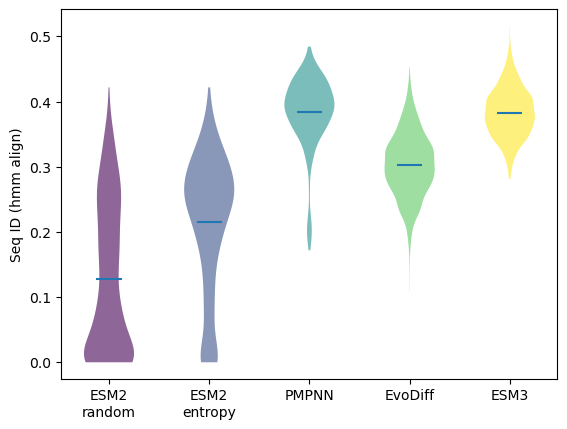

In [12]:
fig, ax = plt.subplots(1,1)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(seq_ids))]
vp = ax.violinplot(seq_ids, showmeans=True, showextrema=False)
_ = ax.set_ylabel('Seq ID (hmm align)')
for c, body in zip(colors, vp['bodies']):
    body.set_facecolor(c)
    body.set_alpha(0.6)
vp['cmeans'].set_color('tab:blue')
_ = ax.set_xticks(ticks=range(1, len(seq_ids) + 1), 
              labels=['ESM2\nrandom', 'ESM2\nentropy', 'PMPNN', 'EvoDiff', 'ESM3'])

In [14]:
for label, seq_id in zip(['ESM2-random', 'ESM2-entropy', 'PMPNN', 'EvoDiff', 'ESM3'], seq_ids):
    print(f'mean seq id {label}: {round(np.mean(seq_id), 2)}')

mean seq id ESM2-random: 0.13
mean seq id ESM2-entropy: 0.22
mean seq id PMPNN: 0.38
mean seq id EvoDiff: 0.3
mean seq id ESM3: 0.38


#### HMM SEARCH

In [15]:
wt_6mfw = os.path.join(data_path, '6mfw_conformations/6mfw_WT_ATC.T.fasta')
pfam_T_hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')

In [16]:
pmpnn_fasta = os.path.join(pmpnn_path, '6mfw_pmpnn_1000.T.fasta')
esm3_fasta = os.path.join(esm3_path, '6mfw_esm3_1000.T.fasta')
evodiff_fasta = os.path.join(evodiff_path, '6mfw_evodiff_1000.T.fasta')
esm2_random_fasta = os.path.join(esm2_random_path, '6mfw_esm2_random_1000.T.fasta')
esm2_entropy_fasta = os.path.join(esm2_entropy_path, '6mfw_esm2_entropy_1000.T.fasta')

In [17]:
# fastas = [pmpnn_fasta, evodiff_fasta, esm3_fasta, esm2_random_fasta, esm2_entropy_fasta]
fastas = [esm2_random_fasta, esm2_entropy_fasta, pmpnn_fasta, evodiff_fasta, esm3_fasta]
hmmer = HmmerTools()
E_values = []
for fasta in fastas:
    df = hmmer.hmmsearch(hmm_path=pfam_T_hmm, fasta_file=fasta)
    E_values.append(-np.log(df['Evalue']))

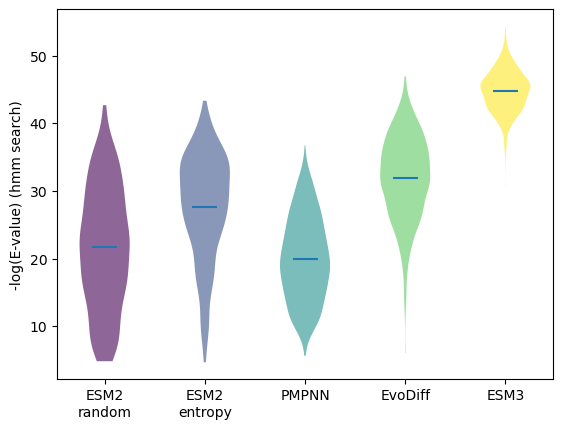

In [18]:
fig, ax = plt.subplots(1,1)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(E_values))]
vp = ax.violinplot(E_values, showmeans=True, showextrema=False)
_ = ax.set_ylabel('-log(E-value) (hmm search)')
for c, body in zip(colors, vp['bodies']):
    body.set_facecolor(c)
    body.set_alpha(0.6)
vp['cmeans'].set_color('tab:blue')
_ = ax.set_xticks(ticks=range(1, len(seq_ids) + 1), 
              labels=['ESM2\nrandom', 'ESM2\nentropy', 'PMPNN', 'EvoDiff', 'ESM3'])

#### Distance to other T domains

In [19]:
from Bio.Blast import NCBIXML
import subprocess

In [20]:
blast_db = '/data/users/kgeorge/workspace/Data/6mfw_conformations/Tdomain_antismash'

In [21]:
pmpnn_fasta = os.path.join(pmpnn_path, '6mfw_pmpnn_1000.T.fasta')
esm3_fasta = os.path.join(esm3_path, '6mfw_esm3_1000.T.fasta')
evodiff_fasta = os.path.join(evodiff_path, '6mfw_evodiff_1000.T.fasta')
esm2_random_fasta = os.path.join(esm2_random_path, '6mfw_esm2_random_1000.T.fasta')
esm2_entropy_fasta = os.path.join(esm2_entropy_path, '6mfw_esm2_entropy_1000.T.fasta')

In [22]:
# fastas = [pmpnn_fasta, evodiff_fasta, esm3_fasta, esm2_random_fasta, esm2_entropy_fasta]
# closest_seq_ids = []
# for fasta in fastas:
#     result_file = os.path.basename(fasta).split('.')[0] + '_result.xml'
#     subprocess.run(["/data/users/kgeorge/workspace/blast/ncbi-blast-2.16.0+/bin/blastp", 
#                     "-query", fasta, "-db", blast_db, "-out", result_file, "-outfmt", "5",
#                     "-num_threads", "8"])

In [23]:
# fastas = [pmpnn_fasta, evodiff_fasta, esm3_fasta, esm2_random_fasta, esm2_entropy_fasta]
fastas = [esm2_random_fasta, esm2_entropy_fasta, pmpnn_fasta, evodiff_fasta, esm3_fasta]
closest_seq_ids = []
for fasta in fastas:
    result_file = os.path.basename(fasta).split('.')[0] + '_result.xml'
    
    with open(result_file) as f:
        blast_rec = NCBIXML.parse(f)
        blast_rec = list(blast_rec)

    print(f'num records: {len(blast_rec)}')

    temp = []
    for rec in blast_rec:
        if len(rec.alignments) > 0:
            temp.append(rec.alignments[0].hsps[0].identities/rec.alignments[0].hsps[0].align_length)

    closest_seq_ids.append(temp)

num records: 986
num records: 983
num records: 1000
num records: 1000
num records: 1000


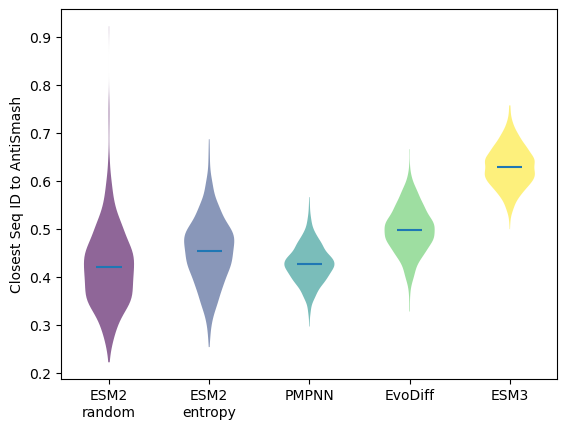

In [24]:
fig, ax = plt.subplots(1,1)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(closest_seq_ids))]
vp = ax.violinplot(closest_seq_ids, showmeans=True, showextrema=False)
_ = ax.set_ylabel('Closest Seq ID to AntiSmash')
for c, body in zip(colors, vp['bodies']):
    body.set_facecolor(c)
    body.set_alpha(0.6)
vp['cmeans'].set_color('tab:blue')
_ = ax.set_xticks(ticks=range(1, len(closest_seq_ids) + 1), 
              labels=['ESM2\nrandom', 'ESM2\nentropy', 'PMPNN', 'EvoDiff', 'ESM3'])

In [25]:
for label, seq_id in zip(['ESM2-random', 'ESM2-entropy', 'PMPNN', 'EvoDiff', 'ESM3'], closest_seq_ids):
    print(f'mean closest seq id {label}: {round(np.mean(seq_id), 2)}')

mean closest seq id ESM2-random: 0.42
mean closest seq id ESM2-entropy: 0.45
mean closest seq id PMPNN: 0.43
mean closest seq id EvoDiff: 0.5
mean closest seq id ESM3: 0.63


#### Moif check

In [45]:
import re
def search_and_filter_motif(records, pattern: str = 'FF.{2}GGHS'):
    '''
        Extend to list of sequences or dict?
        Extend to save list to fasta or return selected sequences
    '''
    matches = []
    for rec in records:
        if re.search(pattern, str(rec.seq)):
            matches.append(rec.id)
    
    # print(f'{len(matches)*100/len(records)}% records contain motif')

    return matches

In [55]:
pmpnn_fasta = os.path.join(pmpnn_path, '6mfw_pmpnn_1000.T.fasta')
esm3_fasta = os.path.join(esm3_path, '6mfw_esm3_1000.T.fasta')
evodiff_fasta = os.path.join(evodiff_path, '6mfw_evodiff_1000.T.fasta')
esm2_random_fasta = os.path.join(esm2_random_path, '6mfw_esm2_random_1000.T.fasta')
esm2_entropy_fasta = os.path.join(esm2_entropy_path, '6mfw_esm2_entropy_1000.T.fasta')


fastas = [pmpnn_fasta, evodiff_fasta, esm3_fasta, esm2_random_fasta, esm2_entropy_fasta]
for fasta in fastas:
    # search_and_filter_motif(helper.read_fasta(gen))
    metrics.search_and_filter_motif(fasta, pattern='F[FL].{2}GG.{1}S')

2.5% records contain motif
75.2% records contain motif
99.0% records contain motif
13.488843813387424% records contain motif
35.09664292980671% records contain motif
